<a href="https://colab.research.google.com/github/SurajK7/ChestAI/blob/master/Progressive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import warnings
warnings.filterwarnings('ignore')

In [0]:
%reload_ext autoreload
%autoreload 2

In [0]:
from fastai.vision import *
from torchvision.models import *
from utils import create_dfs, create_data, print_val_score, chexpert_targets, u_one_features, u_zero_features
from google.colab import drive
import pandas as pd
from pathlib import Path

In [0]:
drive.mount('/content/drive')

In [0]:
cp /content/drive/My\ Drive/CheXpert-v1.0-small.zip .

In [0]:
!unzip -qq CheXpert-v1.0-small.zip
!rm CheXpert-v1.0-small.zip

In [0]:
drive.flush_and_unmount()

In [0]:
full_train_df, full_valid_df = create_dfs()
full_df = pd.concat([full_train_df, full_valid_df])

In [0]:
# function to create class labels
def feature_string(row):
    feature_list = []
    for feature in u_one_features:
        if row[feature] in [-1,1]:
            feature_list.append(feature)
            
    for feature in u_zero_features:
        if row[feature] == 1:
            feature_list.append(feature)
            
    return ';'.join(feature_list)

In [0]:
#adding class labels
full_df['feature_string'] = full_df.apply(feature_string,axis = 1).fillna('')

In [0]:
data = create_data(full_df, size=160, bs=224)

In [0]:
learn = cnn_learner(data, models.densenet121, pretrained=True)

epoch,train_loss,valid_loss,avg_auc_metric,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 4.79E-02
Min loss divided by 10: 1.74E-02


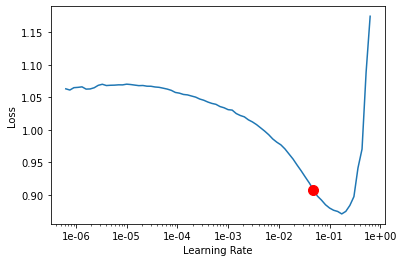

In [0]:
lr_find(learn)
learn.recorder.plot(suggestion=True)

In [0]:
lr = 4e-2

In [0]:
learn.fit_one_cycle(8, slice(lr), callbacks=[callbacks.SaveModelCallback(learn, every='improvement')])

epoch,train_loss,valid_loss,avg_auc_metric,time
0,0.411688,0.494113,0.862800,34:15
1,0.413830,0.448448,0.877092,32:22
2,0.406215,0.461659,0.880548,32:45
3,0.401634,0.502621,0.880560,32:32
4,0.393472,0.456900,0.882534,33:05
5,0.388908,0.429421,0.880053,33:30
6,0.380341,0.430459,0.876548,33:48
7,0.379005,0.437724,0.871350,33:48


Better model found at epoch 0 with avg_auc_metric value: 0.8628002591873368.
Better model found at epoch 1 with avg_auc_metric value: 0.8770917029225788.
Better model found at epoch 2 with avg_auc_metric value: 0.88054847526358.
Better model found at epoch 3 with avg_auc_metric value: 0.8805600805820655.
Better model found at epoch 4 with avg_auc_metric value: 0.8825344471308408.


In [0]:
learn.load('bestmodel')
validation_eval(learn, full_valid_df)

234 234
Atelectasis     	 auc: 0.802	 chexpert auc: 0.858	 difference:    0.0563
Cardiomegaly    	 auc: 0.838	 chexpert auc: 0.854	 difference:    0.0157
Consolidation   	 auc: 0.906	 chexpert auc: 0.939	 difference:    0.0326
Edema           	 auc: 0.915	 chexpert auc: 0.941	 difference:    0.0258
Pleural Effusion	 auc: 0.929	 chexpert auc: 0.936	 difference:    0.00689

Average auc: 0.878 	 CheXpert average auc 0.906	 Difference 0.0275


In [0]:
learn.unfreeze()

Min numerical gradient: 3.02E-05
Min loss divided by 10: 9.12E-06


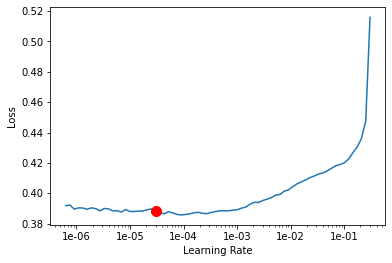

In [0]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [0]:
learn.fit_one_cycle(6, slice(3e-5, lr/10), callbacks=[callbacks.SaveModelCallback(learn, every='improvement', name='unfreeze160')])

epoch,train_loss,valid_loss,avg_auc_metric,time
0,0.388748,0.428049,0.875215,35:23
1,0.389318,0.426862,0.872236,34:09
2,0.381893,0.447940,0.872603,33:56
3,0.376068,0.438199,0.879741,37:06
4,0.368433,0.437952,0.875741,34:54
5,0.368017,0.431020,0.881101,34:39


Better model found at epoch 0 with avg_auc_metric value: 0.8752147018826738.
Better model found at epoch 3 with avg_auc_metric value: 0.8797409765678942.
Better model found at epoch 5 with avg_auc_metric value: 0.8811012029531187.


In [0]:
learn.load('unfreeze160')

In [0]:
data = create_data(full_df, size=320, bs=56)

In [21]:
learn.data = data
data.train_ds[0][0].shape

torch.Size([3, 320, 320])

In [0]:
learn.freeze()

In [0]:
learn.summary()

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 3.98E-03


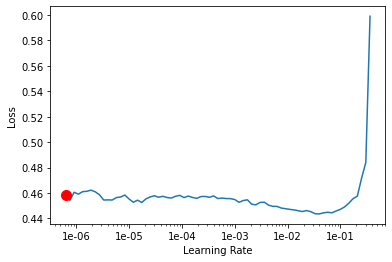

In [24]:
lr_find(learn)
learn.recorder.plot(suggestion=True)

In [0]:
lr = 1e-2

In [0]:
learn.fit_one_cycle(8, slice(lr), callbacks=[callbacks.SaveModelCallback(learn, every='epoch', name='freeze320')])

In [28]:
print_val_score(learn, full_valid_df)

freeze320_3


0.8870451287580865
freeze320_2


0.8860693861181421
freeze320_5


0.8712221334379766
freeze320_0


0.872040925430223
freeze320_6


0.8781401680066802
freeze320_4


0.8801877962786131
freeze320_1


0.8576039065774396
